In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-03 19:56:35.902829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=8, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=8, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [3]:
from torch.utils.data import DataLoader, TensorDataset

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
dataset_train = VitalSignsDataset(vital_signs_train)

labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
small_data_iter = iter(train_loader) 
inputs, lengths,idx,cat  = next(small_data_iter)   

original_indices = torch.arange(len(inputs))
small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# stage1_dir = os.path.join(base_dir, "stage1")
stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, small_train_loader, device, optimizer=optimizer_ae, start=0,epochs=1000, save_dir=stage1_dir, patience=200,kl_warmup_epochs=500)

[Epoch 9] KL weight: 0.0000, KL: 0.0075
[Epoch 19] KL weight: 0.0000, KL: 0.0163
[Epoch 29] KL weight: 0.0001, KL: 0.0251
[Epoch 39] KL weight: 0.0001, KL: 0.0343
[Epoch 49] KL weight: 0.0001, KL: 0.0430
[VAE Pretrain] Epoch 50/1000 Avg ELBO: -204.7957 (Recon: -204.8387, KLw: 0.0430)
[Epoch 59] KL weight: 0.0001, KL: 0.0525
[Epoch 69] KL weight: 0.0001, KL: 0.0620
[Epoch 79] KL weight: 0.0002, KL: 0.0720
[Epoch 89] KL weight: 0.0002, KL: 0.0804
[Epoch 99] KL weight: 0.0002, KL: 0.0920
[VAE Pretrain] Epoch 100/1000 Avg ELBO: -232.9404 (Recon: -233.0324, KLw: 0.0920)
[Epoch 109] KL weight: 0.0002, KL: 0.1007
[Epoch 119] KL weight: 0.0002, KL: 0.1111
[Epoch 129] KL weight: 0.0003, KL: 0.1205
[Epoch 139] KL weight: 0.0003, KL: 0.1319
[Epoch 149] KL weight: 0.0003, KL: 0.1414
[VAE Pretrain] Epoch 150/1000 Avg ELBO: -253.6924 (Recon: -253.8338, KLw: 0.1414)
[Epoch 159] KL weight: 0.0003, KL: 0.1520
[Epoch 169] KL weight: 0.0003, KL: 0.1621
[Epoch 179] KL weight: 0.0004, KL: 0.1731
[Epoch 189

In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [ ]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [ ]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=80,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/80 Avg Loss: 0.0172
[SOM] Phase 1 Epoch 20/80 Avg Loss: 0.0172
[SOM] Phase 2 Epoch 30/80 Avg Loss: 0.0172
[SOM] Phase 2 Epoch 40/80 Avg Loss: 0.0172
[SOM] Phase 2 Epoch 50/80 Avg Loss: 0.0172
[SOM] Phase 3 Epoch 60/80 Avg Loss: 0.0152
[SOM] Phase 3 Epoch 70/80 Avg Loss: 0.0151


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [ ]:
# stage3_dir = os.path.join(base_dir, "stage3")

stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, small_train_loader, small_train_loader,small_train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 16 patients. Total length: 3700
[Joint] Ep1: Calculating global target P...


[Joint] Ep1 Global P updated. Shape: torch.Size([3700, 100])


RuntimeError: The size of tensor a (503) must match the size of tensor b (8048) at non-singleton dimension 1

: 

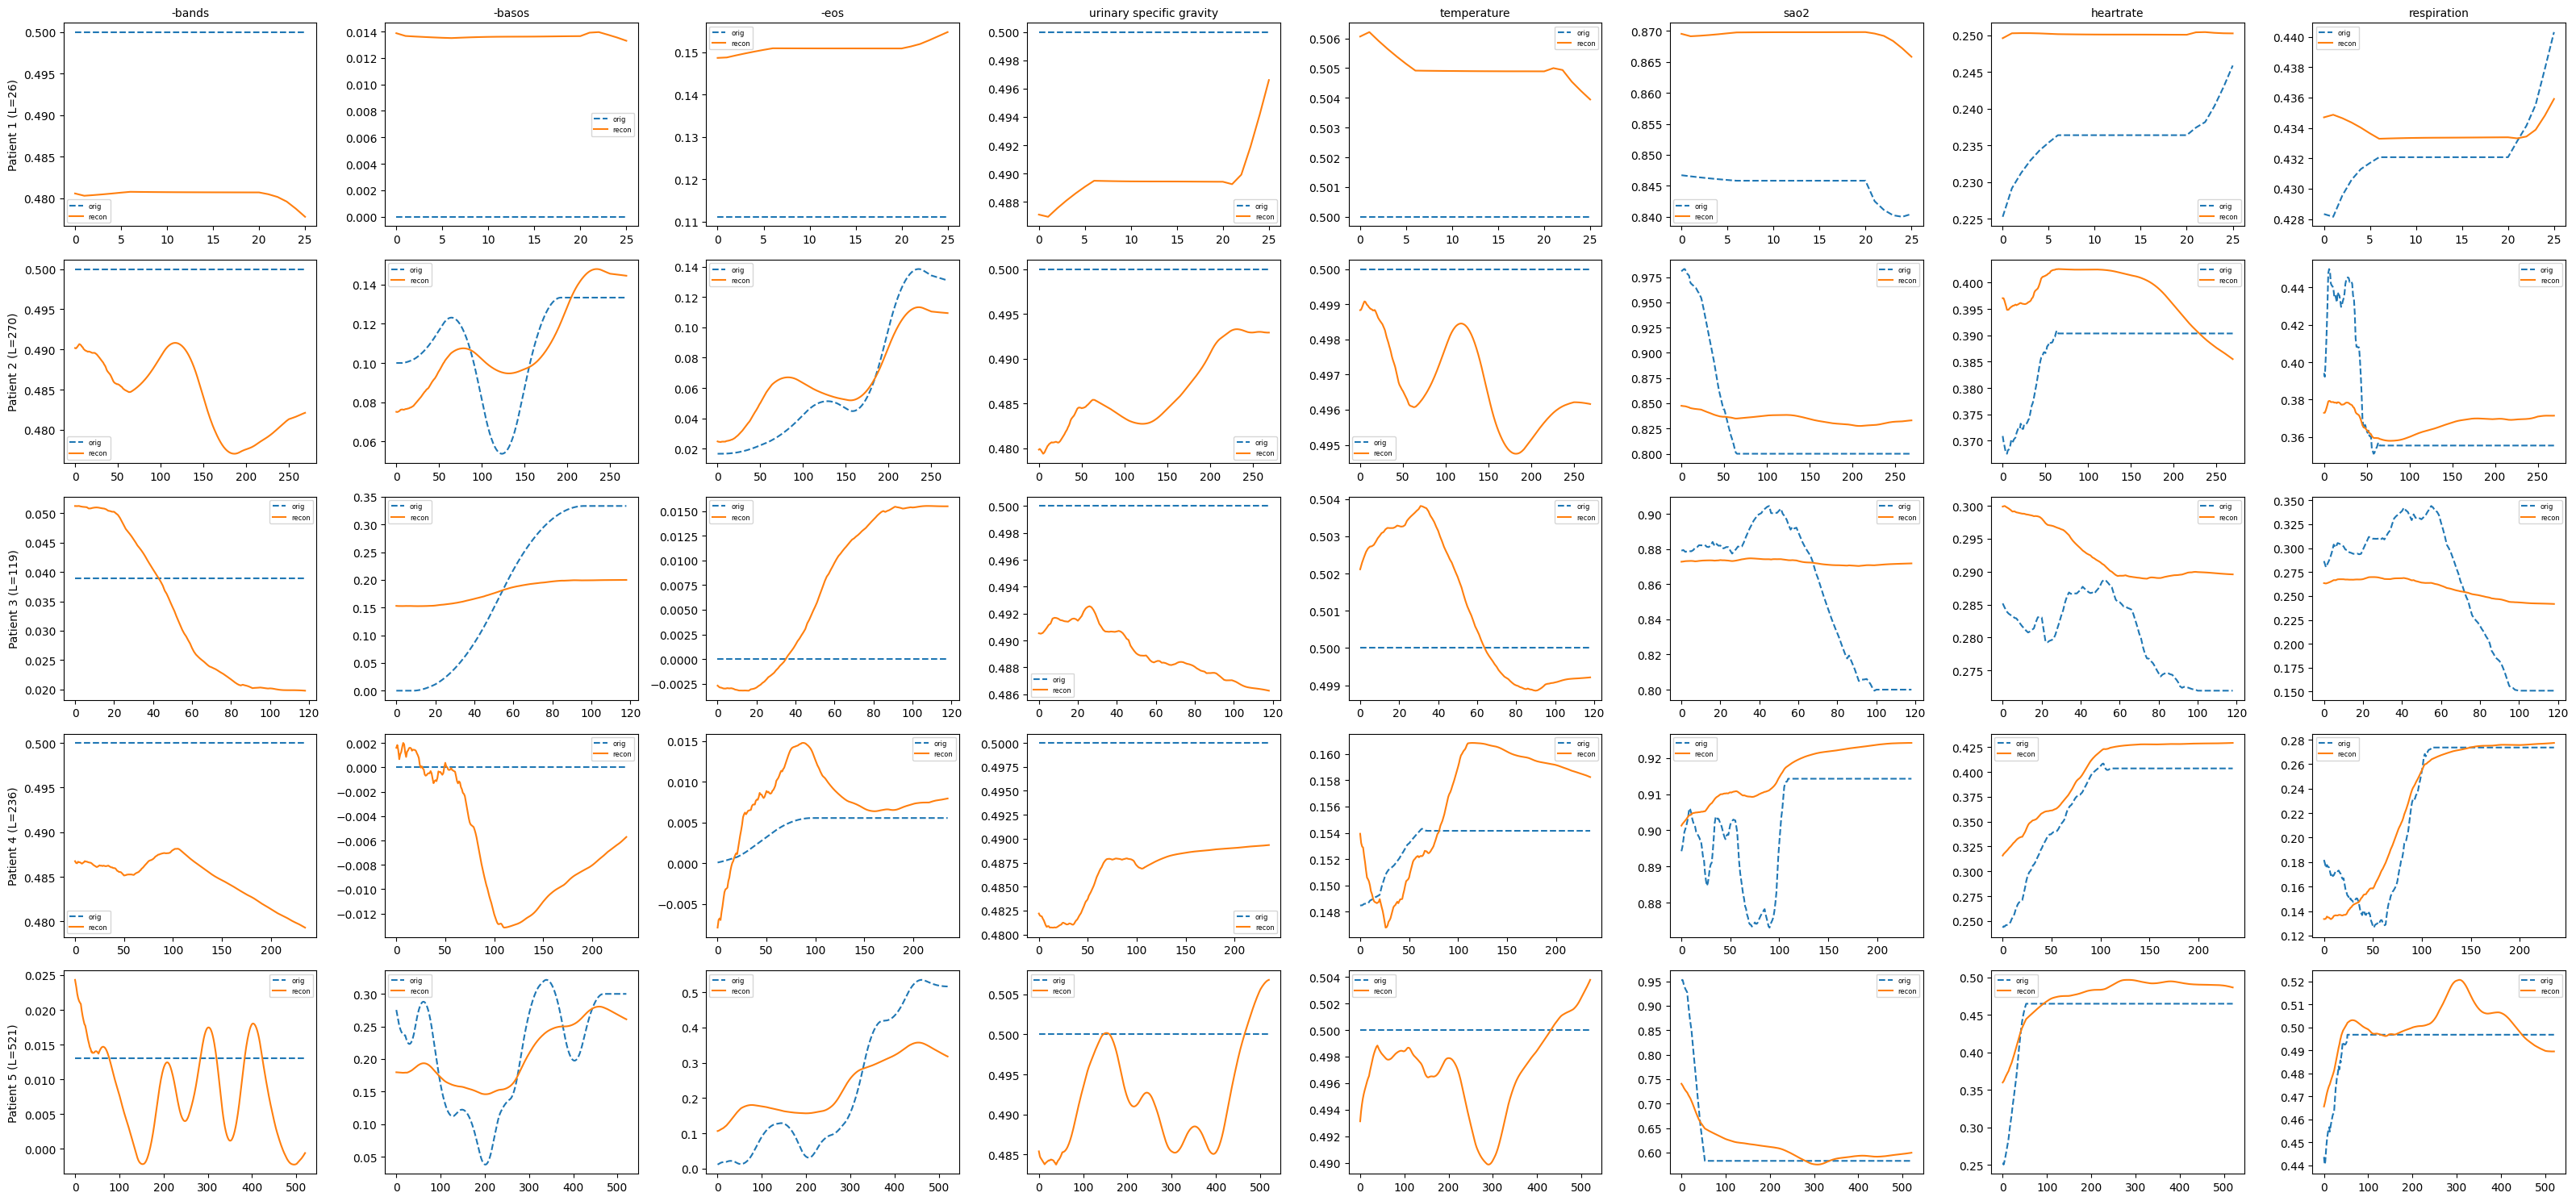

In [11]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model1, small_train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 4872 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0271
  Std (overall): 0.8013
  Per-dim mean:
tensor([-2.6590e-01, -4.8676e-04, -9.3230e-02, -1.7540e-01, -1.0006e+00,
         2.5309e-02,  1.1032e+00, -1.8897e-01, -6.3279e-01,  8.8552e-02,
        -3.1450e-02,  4.1202e-02,  2.1049e-01, -1.4164e-02, -3.8593e-01,
         3.5535e-03, -1.2946e-02, -1.7456e-02, -2.4130e-02, -5.1004e-02,
        -1.4985e-01, -1.1295e+00, -4.0123e-01,  9.5240e-01, -3.0307e-01,
        -7.6089e-01, -2.6559e-03, -3.9294e-01,  5.0877e-01, -6.4531e-02,
         2.8343e-02, -8.9118e-01,  2.7422e-03, -2.3032e-02,  1.2339e-02,
         1.4672e+00, -2.0370e-02,  1.5358e-01, -3.9510e-01, -8.1382e-01,
         6.3139e-01,  1.8289e-02,  3.6065e-02,  1.6264e+00,  1.1255e+00,
        -8.5120e-02,  2.4256e-01, -4.3738e-03, -2.4005e-01,  2.2012e-02,
        -1.2211e+00, -6.0912e-02, -5.0290e-03,  3.5111e-01,  1.3404e-02,
         1.6688e-02, -3.5177e-01,  1.24

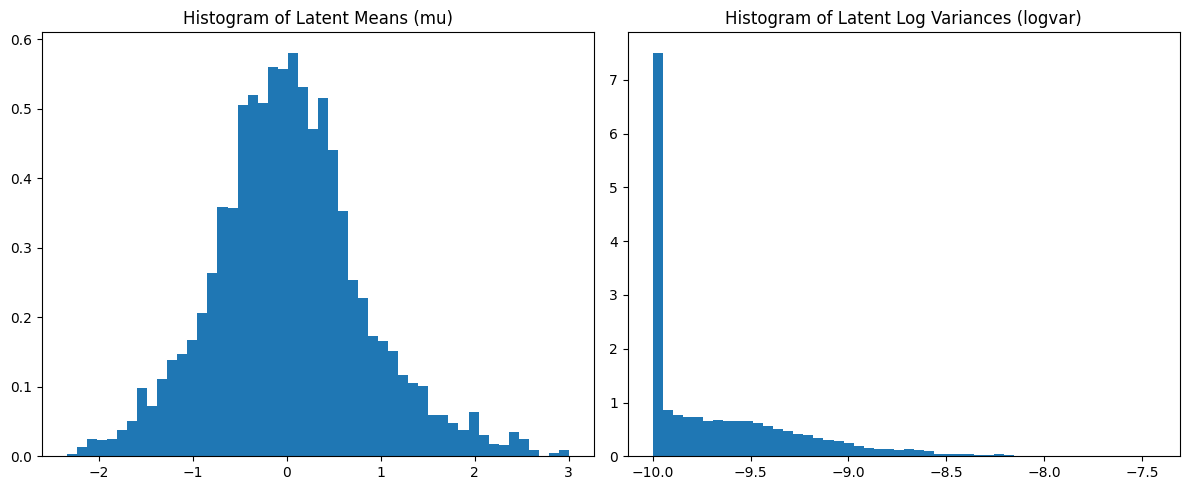

In [12]:
analyze_latent_stats(model1, small_train_loader, device, num_batches_to_analyze=20)

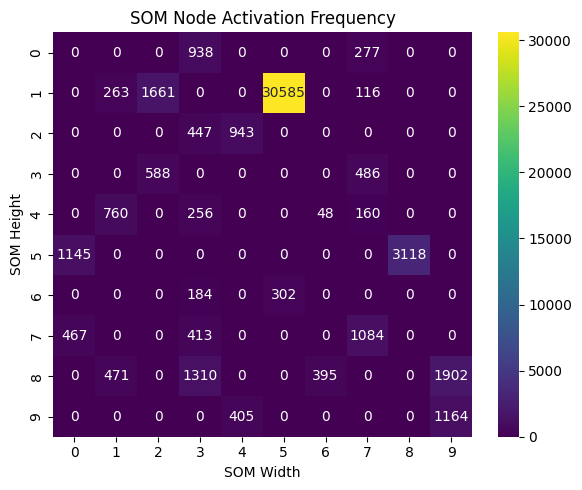

In [ ]:
activation_map = compute_som_activation_heatmap(model2, small_train_loader, device)
plot_som_activation_heatmap(activation_map)

z_all shape: (18250, 64)
y_all shape: (18250,)


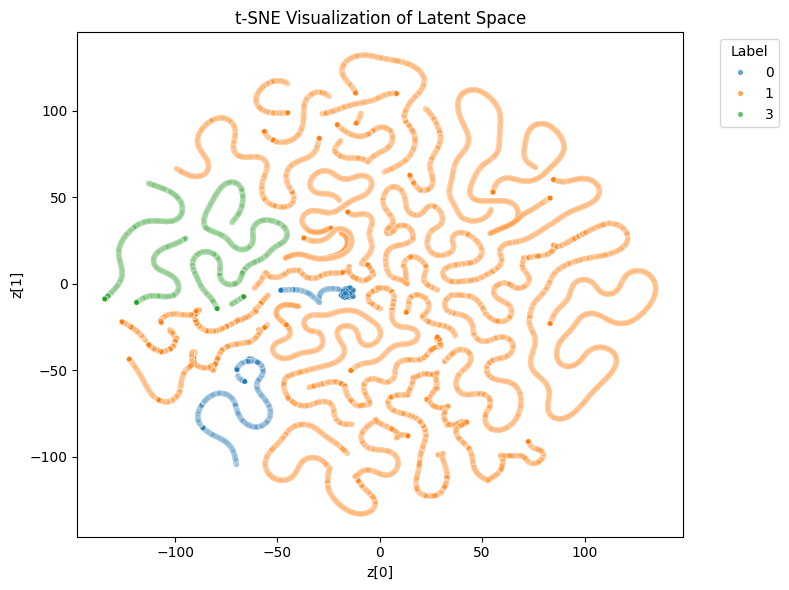

In [ ]:
z_all, y_all = collect_latents(model, data_loader=small_train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


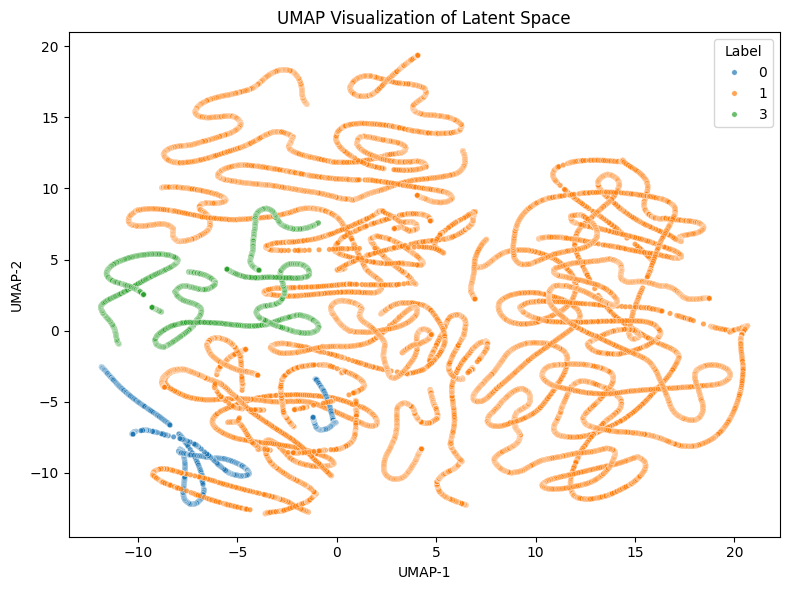

In [ ]:
plot_umap(z_all, y_all)
